In [24]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import sklearn
from matplotlib import pyplot as plt
import math
from __future__ import division
# import seaborn as sns
import seaborn as sns
sns.set_style('whitegrid')

In [6]:
# Import NCDC dataset
ipath= "./data/NCDC/marham.txt"
uipath = unicode(ipath , "utf8")
file2 = open(uipath)
df = pd.read_csv(uipath,header=0, skipinitialspace=True)
df.drop(['USAF', 'NCDC', 'I','QCP','Q','Q.1','I.1','Unnamed: 12'], 1,inplace=True)
df.rename(columns={'Date':'date','Dir': 'dir', 'Spd':'speed'}, inplace=True)
df.describe()

,date,HrMn,dir,speed
count,5.235770e+05,523577.000000,523577.000000,523577.000000
mean,1.996384e+07,1162.473529,208.605273,4.762744
std,1.370768e+05,689.468339,143.137319,8.372933
min,1.949080e+07,0.000000,10.000000,0.000000
25%,1.987111e+07,600.000000,130.000000,2.600000
50%,1.999083e+07,1150.000000,210.000000,4.100000
75%,2.008031e+07,1750.000000,260.000000,6.200000
max,2.015080e+07,2355.000000,999.000000,999.900000


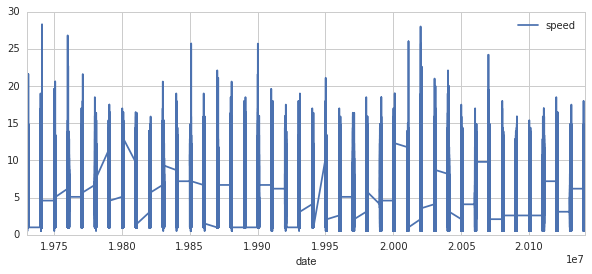

In [7]:
# Select year 1945-2014, dir < 999, speed<999
df = df[(df['dir'] < 999) & (df['speed'] < 999)& (df['date'] > 19720000) &(df['date'] < 20150000)]
df.rename(columns={'speed':'speed_mps'}, inplace=True)
df['speed']=df['speed_mps']
df.index= df['date']
df['speed'].plot(legend=True,figsize=(10,4), grid=True)

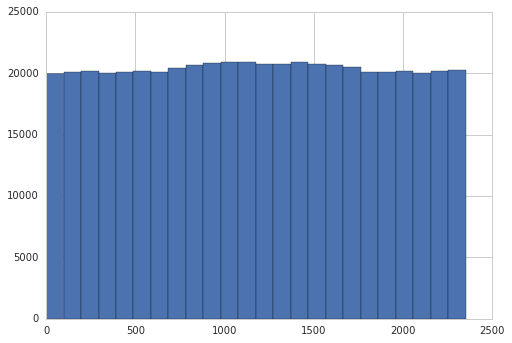

In [8]:
# Check time sample distribution,
# and found that its not equally sampled.
time = df[df['HrMn'] % 10 <= 0.1]
time['HrMn'].hist(bins = 24)

In [9]:
df=df[df['Type']=='FM-15']
# df=df[df['Type']=='FM-12']

In [10]:
df['artifact'] = False

# Simple artifact detection
# 1. dir error
df.ix[df['dir'] % 10 >=0.1,'artifact']=True
artifact = df[df['dir'] % 10 >=0.1]
print len(artifact)

3


In [11]:
# 2. Speed remain error
# Generate the first digit of fractional part of the speed(after convert to knot unit)
# e.g. 48.5 -> 5
# import math
# df['speed']=df['speed_mps']*1.943845
# df['speed_remain'] = df['speed'].apply(lambda x: math.modf(x*10 % 10)[1])

# # Plot the distribution of speed_remain,
# # and compare between year<2000 and > 2000
# temp = df[(df['date'] > 20000000)]
# temp['speed_remain'].hist(bins = 10,alpha=0.5)
# print temp['speed_remain'].value_counts()

# temp = df[(df['date'] < 20000000)]
# temp['speed_remain'].hist(bins = 10,alpha=0.5)
# print temp['speed_remain'].value_counts()

In [12]:
# # From the distribution above, 
# # we can know that the legit number are only 0 and 9, all others are too rare to be normal.
# df.ix[(df['speed_remain'] >= 2)&(df['speed_remain'] <= 7),'artifact']=True
# df.drop(['speed_remain'], 1,inplace=True)
# # and then converted the speed into integer
# df.rename(columns={'speed':'speed_flt'}, inplace=True)
# df['speed'] =  df['speed_flt'].apply(lambda x: int(round(x)))
# df[df['artifact']== True].head(20)

In [13]:
df['speed'] =  df['speed_mps'].apply(lambda x: int(round(x*1.943845)))

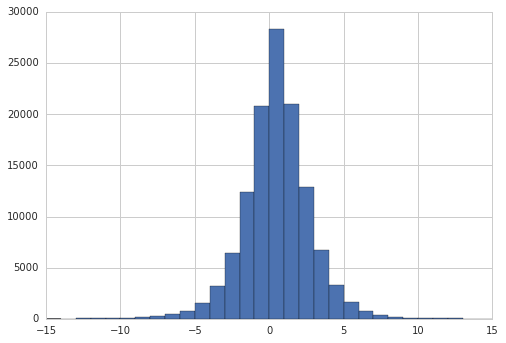

In [14]:
# pd.set_option('display.max_rows', 100)

df['incre'] = df.speed.diff(1)
df['incre'] = df['incre'].fillna(0)
df['incre_reverse'] = df.speed.diff(-1)
df['incre_reverse'] = df['incre_reverse'].fillna(0)
bins=np.arange(-15, 15 + 1, 1)
df['incre'].hist(bins=bins)
# df.sort('speed',ascending=False).head(30)
# print df['incre'].value_counts()

In [15]:
# df[(df['date'] >= 19790110)].head(60)
# df[(df['date'] >= 19741029)].head(60)

In [16]:
# 3. Artifact detection: sudden increase
# detect udden increase from nearby data, consider singular increase
artifact = df[((df['incre'] >= 7)&(df['incre_reverse'] >= 7))]
df.ix[((df['incre'] >= 7)&(df['incre_reverse'] >= 7)),'artifact']=True
print len(artifact)
artifact

162


,date,HrMn,Type,dir,speed_mps,speed,artifact,incre,incre_reverse
date,,,,,,,,,
19870522,19870522,800,FM-15,20,8.2,16,False,11.0,13.0
19870820,19870820,1400,FM-15,190,7.2,14,False,12.0,9.0
19870912,19870912,1313,FM-15,220,12.9,25,False,13.0,22.0
19871016,19871016,1326,FM-15,230,11.8,23,False,14.0,13.0
19880104,19880104,2100,FM-15,250,9.8,19,False,14.0,10.0
19880210,19880210,1500,FM-15,250,12.4,24,False,12.0,13.0
19880216,19880216,1341,FM-15,300,8.2,16,False,11.0,8.0
19880223,19880223,1500,FM-15,330,9.8,19,False,12.0,8.0
19880315,19880315,1050,FM-15,200,9.3,18,False,16.0,12.0


In [17]:
artifact = df[((df['incre'] <= -7)&(df['incre_reverse'] <= -7))]
df.ix[((df['incre'] <= -7)&(df['incre_reverse'] <= -7)),'artifact']=True
print len(artifact)
artifact

103


,date,HrMn,Type,dir,speed_mps,speed,artifact,incre,incre_reverse
date,,,,,,,,,
19880117,19880117,1500,FM-15,200,4.6,9,False,-10.0,-7.0
19880205,19880205,1500,FM-15,210,6.2,12,False,-10.0,-12.0
19880312,19880312,2100,FM-15,10,1.0,2,False,-7.0,-16.0
19880521,19880521,500,FM-15,140,1.0,2,False,-7.0,-14.0
19881130,19881130,1720,FM-15,190,1.0,2,False,-11.0,-10.0
19881228,19881228,608,FM-15,190,3.1,6,False,-12.0,-9.0
19890128,19890128,1750,FM-15,310,1.5,3,False,-14.0,-10.0
19890224,19890224,608,FM-15,160,4.6,9,False,-8.0,-7.0
19890308,19890308,608,FM-15,210,1.0,2,False,-12.0,-13.0


In [18]:
### Summary of artifacts, which belongs to FM-15
# 3 types are handled:
# 1. Sudden increase in speed, e.g. 5, 50, 5. the 50 is detected
# 2. Strange wind direction record, e.g. 61, 78, 127, since wind dir are setcored into 10 degree
# 3. Speed not near an integer after converting back to knot, e.g. 23.4, 7.75

artifact = df[(df['artifact']==True)]
print len(artifact)
artifact

268


,date,HrMn,Type,dir,speed_mps,speed,artifact,incre,incre_reverse
date,,,,,,,,,
19870522,19870522,800,FM-15,20,8.2,16,True,11.0,13.0
19870820,19870820,1400,FM-15,190,7.2,14,True,12.0,9.0
19870912,19870912,1313,FM-15,220,12.9,25,True,13.0,22.0
19871016,19871016,1326,FM-15,230,11.8,23,True,14.0,13.0
19880104,19880104,2100,FM-15,250,9.8,19,True,14.0,10.0
19880117,19880117,1500,FM-15,200,4.6,9,True,-10.0,-7.0
19880205,19880205,1500,FM-15,210,6.2,12,True,-10.0,-12.0
19880210,19880210,1500,FM-15,250,12.4,24,True,12.0,13.0
19880216,19880216,1341,FM-15,300,8.2,16,True,11.0,8.0


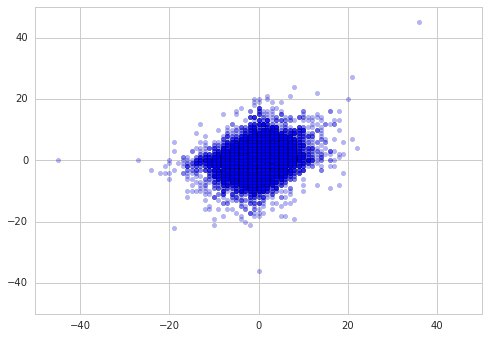

In [19]:
import pylab
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
# new_set = [df['incre'],df['incre_reverse']]
X = df['incre']
Y = df['incre_reverse']

plt.scatter(X, Y, alpha = 0.3)
# plt.contour(X, Y, alpha=.75, cmap='jet')

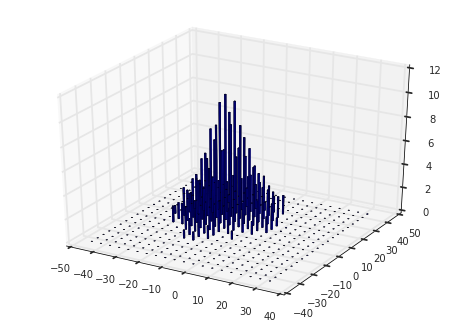

In [20]:
# %matplotlib qt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# x, y = np.random.rand(2, 100) * 4
x = df['incre']
y = df['incre_reverse']
hist, xedges, yedges = np.histogram2d(x, y, bins=20)

elements = (len(xedges) - 1) * (len(yedges) - 1)
xpos, ypos = np.meshgrid(xedges[:-1]+0.25, yedges[:-1]+0.25)

xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(elements)
dx = 0.5 * np.ones_like(zpos)
dy = dx.copy()
# dz is the count
dz = np.log(hist.flatten())

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
plt.show()

In [21]:
# sample = np.array(zip(df['incre'], df['incre_reverse']))

# # Empirical Distribution
# from sklearn.neighbors import KernelDensity
# from itertools import product
# from math import *

# X = np.arange(-15, 15, 1)
# Y = np.arange(-15, 15, 1)
# N, M = len(X), len(Y)
# Z = np.zeros((N, M))
# for i, (x,y) in enumerate(product(X,Y)):
#     Z[np.unravel_index(i, (N,M))] = # count of the number of (x,y)

# fig, ax = plt.subplots(figsize=(8, 8), dpi=80)
# ax.set_aspect('equal')
# plt.contourf(X, Y, Z.T, 10, alpha=.75, cmap='jet')
# plt.colorbar()
# range(-20,20)